# Exploring Word Embeddings & Polysemy

5/11/2018 - 5/14/2018

**Table of Contents:**

1. Upload and Clean/Preprocess Data
2. Learn Word2Vec Word Embeddings
3. Explore Word2Vec Word Embeddings  (3A. Word Similarities & Robustness, 3B. Visualization & Robustness)
4. Word Embeddings as Features to Predict Author Gender
5. Polysemy



In [1]:
#import libraries needed
import re
from string import digits
import pandas as pd
import os
import numpy as np
import string
import sys
import cython #ENSURE cython package is installed on computer/conda
import numpy as np
from gensim.models import word2vec
from gensim.models import phrases 
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy import spatial
import csv
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold 
from sklearn import svm
from sklearn.cluster import KMeans
import pylab as pl

cwd= os.getcwd() #cwd is current working directory, setting this now makes it easier to enter file paths

C:\Users\Alina Arseniev\Anaconda3\envs\ipykernel_py2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1. Upload Southern Narratives Data and Clean/Preprocess

The data I use in this exam is the 'First-Person Narratives of the American South'. It is freely available and downloadable from: http://docsouth.unc.edu/docsouthdata/

" 'First-Person Narratives of the American South' comprises 150 Southerners' narratives on their lives through their letters, memoirs, autobiographies and other writings. Represented indivdiuals include slaves, laborers, women, aristocrats, soldiers, and officers, and narratives were published from approximately 1838 to 1921. 

In [2]:
#upload text files, there should be 150 of them, 1 for each narrative. 
corpus =[]
for filename in os.listdir(cwd + '/first-person-narratives-american-south/data/texts'):
    narrative= open( cwd + '/first-person-narratives-american-south/data/texts/' + filename , 'r') #cwd likley will need to be changed for reproducibility
    corpus.append(narrative.read())  #.decode('utf-8') if needed, seems to vary across operating systems? 
len(corpus)==150 #a check!

True

**Cleaning and pre-processing the corpus**

From visually looking at the data, it is already pretty clean. Most importantly, letters need to be all lowercased, digits removed, and punctuation removed. And, the corpus needs to be re-structured for Word2Vec into a list of "sentences." I've separated sentences using periods, but also quotation, exclamation and question marks, and colons and semi-colons. I strip any extra whitespace, and within each "sentence" tokenize the string such that each word is a token.

More subjective choices for pre-processing in natural language processing commonly include removing stop words (words that are frequent but sometime considered meaningless, such as "the") and stemming words (e.g., reducing all words to a single tense, like "running and "runs" to "run"). I do not remove stop words, since I do not buy that these are always "meaningless," and from my understanding of Word2Vec, it is well designed to extract any meaning from stop words if it is there (i.e., if it predicts other words' meaning), or place little emphasis on stop words (or noise) if they do not predict other words' meaning. Further, I do not stem words, since I see the endings of words as information. This dataset isn't so small that there are few instances of each vocabulary word (150 documents and around 8 million tokens), and stemming is most helpful as a strategy to reduce the vocabulary size and increase the number of instances of each vocabulary word.


In [3]:
corpus_clean=[]
for document in corpus:  #consulted my MA code for text cleaning code
    doc = re.sub(';?:!"', '.', document) #replace these with period, they will be splits for sentences
    doc = re.sub(r'[^\w\s.]', '', doc)  #remove all remaining punctuation except periods
    doc = doc.translate(None, digits) #remove digits
    doc = doc.lower()  #make all letters lowercase
    doc = re.sub(r'\s+', ' ',   doc) #remove any extra white spaces, from https://lzone.de/examples/Python%20re.sub
    doc= doc.split('.') #split document into sentences
    doc2 = [j.strip().split(' ') for j in doc] #split up each sentence into tokens and strip any extra whitespace if remaining
    for i in doc2:
        filter(None, i) #get rid of empty tokens, ''
    corpus_clean.extend(doc2) #attach sentences to corpus_clean

del(corpus) #save up some space
#corpus_clean[0][0:10] #look to see if first sentence is accurately portayed, compare to first text file in file 

In [4]:
print("Total sentences in corpus: " + str(len(corpus_clean)))  #384,145 sentences
print("Total tokens in corpus: " + str(len([y for x in corpus_clean for y in x]))) #length of flattened list of sentences. 8,097,489 tokens

Total sentences in corpus: 384145
Total tokens in corpus: 8097489


Re-sample sentences with replacement. We'll train another models using this re-sampled corpus, and doing analyses on this resampled coprora will provide us a sense of robustness of the results from analyses. Here, we're only training one resampled modeled since each model takes some time to train but this could be extended to mutliple models. The number of models might be some large, arbitarty number (a common strategy) or perhaps models might be created until we seem to reach saturation in the variability seen across sampling (uncommon).

In [18]:
corpus_clean_samp1= np.random.choice(corpus_clean, size=len(corpus_clean), replace=True).tolist() #consulted numpy documentation: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html

## 2. Learn Word2Vec Models

Key hyperparameters for Word2Vec incldue the learning architecture (Skip Gram or Context Bag of Words), the dimensionality (which usually ranges 50-1000), and the context window (usually 2-10). Smaller context windows tend to capture syntactic similarities, while larger context windows tend to capture semantic similarities better.  

Notes on a few **hyperparameters**, for a review please see (Rong 2014) and Gensim documentation https://radimrehurek.com/gensim/models/word2vec.html:

* size = word vector dimensionality. usually ranges 50-500 with gains in model performance diminishing after 300. (Mikolov et al. 2013a)
* min_count=5 = minimum word count. Any word that does not occur at least this many times across all documents is ignored. Default is 5. 
* workers = number of threads to run in parallel, I set to 4. This seriously speeds up training, but to use make sure Cython is installed. 
* window = context window size. A larger window captures topical similarity, smaller captures is semantic similarity. (Goldberg 2016, Levy and Goldberg 2014)
* seed= can set a seed for reproducibility, note you also cannot use multiple workers if you want a fully reproducible model.
* sg = learning architecture: skip-gram (1) or CBOW (0). Skip-gram sets up the artificial neural network underlying Word2Vec to predict set of context words given a target word. CBOW, or Context Bag of Words, sets up the network to predict a target word given a set of context words. 
* hs= training algorithm to speed up computations: hierarchical softmax (1) or negative sampling (0)
    
    
Hyperparameters I explore:

For two very important hyperparameters, the learning algorithm (CBOW or SkipGram) and the training algorithm (Hierarchical Softmax of Negative Sampling), I try all four possible combinations. For these four models, I set the number of context words to 10 to emphasize capturing semantic rather than syntactic similarity. I am most interested in semantic similarity. I set the dimensionality to 100 because 1) I am using less data than often used for Word2Vec model training and 2) I want to prioritize speed of model training and speed of future analyses, such as clustering and visualization. To ensure that model quality is not being drastically sacrificed by using lower dimensionality, after selecting my learning algorithm and training algorithm I compare to a model that is trained on 300 dimensions. Similarly, I compare to a model with a context window of 5 rather than 10, as a quick on check my choice of a large context window. For all other hyperparameters, I use the default values in the Gensim implementation of Word2Vec.

For Word2Vec related code, I consulted the Genism website as needed: https://radimrehurek.com/gensim/models/word2vec.html. I also looked at my old MA code. 

In [19]:
#perform on object with the cleaned text data. do this first before training Word2Vec model if you want to allow for bigrams in data (two word expressions, rather than only one word)
bigram_transformer = phrases.Phrases(corpus_clean)  #use for all models except model on resampled data

bigram_transformer_1 = phrases.Phrases(corpus_clean_samp1) #use for the model on resampled data

In [20]:
#Use this code to train various model parameterizations. Model is parametrized below based on "best" model found. 
print("Training model...") 
SG_100_10_1HS_samp1= word2vec.Word2Vec(bigram_transformer_1[corpus_clean_samp1], workers=4, sg=1, hs=1, size=100,  window=10, sample=1e-3)
print("Done") 

Training model...
Done


In [28]:
SG_100_10_1HS_samp1.init_sims(replace=True) #Pre-compute L2-normalized vectors. If replace is set to TRUE, forget the original vectors and only keep the normalized ones = saves lots of memory, but can't continue to train the model.
SG_100_10_1HS_samp1.save("SG_100_10_1HS_samp1") #save trained model in current working directory

**Evaluate Model Accuracy on the Google Analogy Test**

The Google Analogy test is the currently accepted method to evaluate the quality of word-embeddding models. It consists of a series of 20,000 analogies which the model is asked to complete, across a range of semantic and syntactic areas such as world capitals (Paris:France as Mexico City:?). Of course, for various datasets this may range since datasets may not come from the same context (in space and time) as from which the Google Analogy test was created. For example, it is unreasonable to expect the model to perform well on world capitals since theses 1) may have changed since the data was created and 2) are probably rarely discussed in the data. For reference, when originally published, among all hyperparametrizations of Word2Vec explored the best performing model correctly completed 61% of all questions in the Google Analogy test (Mikolov et al. 2013b).

In [33]:
#Upload the saved model SG_100_10_1HS if needed, since this is the model with the highest accuracy found above.
currentmodel=  word2vec.Word2Vec.load("SG_100_10_1HS")

In [34]:
accuracy=currentmodel.wv.accuracy('questions_words_pasted.txt') #FOR THIS TO WORK, NEED TO HAVE THIS TXT FILE IN WORKING DIRECTORY AND OTEHR FILES FOR GOOGLE ANALOGY TEST

In [35]:
world_capitals1= accuracy[0] #seems same as world_capitals1 and 2 and 3??
world_capitals2= accuracy[1] #seems same as world_capitals1 and 2 and 3??
money= accuracy[2]
US_capitals= accuracy[3]
family= accuracy[4]
adj_to_adverbs= accuracy[5]
opposites= accuracy[6]
comparative= accuracy[7]
superlative= accuracy[8]
present_particple= accuracy[9]
nationality= accuracy[10]
past_tense= accuracy[11]
plural = accuracy[12]
plural_verbs= accuracy[13]
word_capitals3= accuracy[14] #seems same as world_capitals1 and 2 and 3??

specific_model_accuracy=[]
for i in accuracy:
    sum_corr = len(i['correct'])
    sum_incorr = len(i['incorrect'])
    total = sum_corr + sum_incorr
    specific_model_accuracy.append(float(sum_corr)/(total))
    print(float(sum_corr)/(total))

#print('Total sentences: {}, Correct: {:.2f}%, Incorrect: {:.2f}%'.format(total, percent(sum_corr), percent(sum_incorr)))
#print sum_corr[1]
#print sum_incorr[1]
#print total

0.152777777778
0.0655737704918
0.0
0.0862785862786
0.494152046784
0.0812807881773
0.0333333333333
0.247899159664
0.214285714286
0.443722943723
0.116766467066
0.496212121212
0.276209677419
0.0761904761905
0.242877401057


In [36]:
print('Average accuracy across sections:' + str(np.mean(specific_model_accuracy)))

Average accuracy across sections:0.20183735089732802


**Tracking Model Accuracy**

| Model   |      Mean Accuracy      |  Notes |
|----------|:-------------:|------:|
| CBOW_100_10_0HS | .15 |  CBOW learning algorithm, 100-dimensions, context window of 10, Negative Sampling training algorithm   |
| CBOW_100_10_1HS | .17  |  CBOW learning algorithm, 100-dimensions, context window of 10, Hierarchical Softmax training algorithm  |
| SG_100_10_0HS | .18  |   Skip Gram learning algorithm, 100-dimensions, context window of 10, Negative Sampling training algorithm  |
| SG_100_10_1HS | .20  |  Skip Gram learning algorithm, 100-dimensions, context window of 10, Hierarchical Softmax training algorithm   |
| SG_300_10_1HS |  .20   |   Extra trained Model to test higher dimensionality for "best" model, 300-dimensional version of SG_100_10_1HS |
| SG_100_5_1HS |   .20    |  Extra trained Model to test smaller context window for "best" model, 5 context window version of SG_100_10_1HS  |
| SG_100_10_1HS_samp1 |   .14    |  Extra trained Model to test how sensitive findings are to sampling.  


These model accuracies are all very low compared to published model accuracies, despite various attempts at different hyperparameterizations (Mikolov et al. 2013b). This could be because there is insufficient training data. More likely, it is also possible that while the google analogy test is good at evaluating word-vector quality on for some natural language processing applications in modern data (like news), it is not a good indicator of model quality for other applications. As mentioned earlier, it is unreasonable to expect accuracy of this data on many sections, such as capitals and currencies. It is also possible that the language used in the Google Analogy test is *syntactically* different form the language used in the narrative data, since they come from different time periods. I'll continue using the "best" among these despite poor accuracy rates, model SG_100_10_1HS, and we'll see how well it does qualitatively when we explore it in the next sections. 

Upon testing the re-sampled version of SG_100_10_1HS, called, SG_100_10_1HS_samp1, we see the accuracy lower to .14. Further testing would be needed to know if this is because of the data or the model parametrization, since only one model was trained for each parametrization (and models can be slightly different from run-to-run). 


## 3. Model Exploring

In [29]:
#Upload the saved model SG_100_10_1HS or resampled versions, since this is the parametrization with the highest accuracy found above.
currentmodel= word2vec.Word2Vec.load("SG_100_10_1HS")

In [148]:
len(currentmodel.wv.vocab) #40,705 unique vocabulary words learned by Word2Vec. Recall that words occuring less than 5 times were dropped as part of default Word2Vec training settings. 

40705

In [75]:
currentmodel.wv.most_similar('man', topn=10) #asks which words are closest to "man"

[(u'girl', 0.8222223520278931),
 (u'old_lady', 0.7281111478805542),
 (u'she', 0.707303524017334),
 (u'lady', 0.7062606811523438),
 (u'child', 0.6939961910247803),
 (u'needlewoman', 0.6687383651733398),
 (u'creature', 0.6679231524467468),
 (u'herself', 0.6595945358276367),
 (u'young_girl', 0.6574671864509583),
 (u'boy', 0.6544568538665771)]

**10 most similar words to "woman", "man", and "southerner"**

| 10 words most similar to "woman"   |      Cosine Similarity      | 
|----------|:-------------:|
| girl | .82 | 
| old_lady | .73  |  
| she |  .71 | 
| lady | .71  |  
| child |  .69 |   
| needlewoman |  .67 |  
| creature |  .67 |  
| herself |  .66 |  
| young_girl |  .66 |  
| boy |  .65 |  

| 10 words most similar to "man"   |      Cosine Similarity      | 
|----------|:-------------:|
| fellow | .75 | 
| noble_fellow | .73  |  
| soldier |  .70 | 
| he | .68  |  
| gentleman |  .67 |
|boy |  .66 |
| citizen |  .65 |
|woman |  .64 |
| southerner |  .64 |
| farmer |  .63 |


| 10 words most similar to "southerner"  |      Cosine Similarity      | 
|----------|:-------------:|
| northerner | .72 | 
| abolitionist | .65  |  
| epithet |  .64 | 
| man | .64  |  
| sentiment|  .65 |   
| muchabused |  .62 |  
| fireeater |  .62 |  
| an_abolitionist |  .62 | 
| grudge_against |  .62 |
| statesman |  .61 |  

In [258]:
print(currentmodel.wv.most_similar(positive=['woman'], negative=['man'], topn=10)) #what are the most feminine words?
print('\n')
print(currentmodel.wv.most_similar(positive=['man'], negative=['woman'], topn=10)) #what are the most masculine words?

[(u'herself', 0.5534662008285522), (u'dainty', 0.4591292440891266), (u'younger_children', 0.4565247893333435), (u'apron', 0.43166297674179077), (u'old_lady', 0.42843860387802124), (u'trousseau', 0.42437154054641724), (u'housekeeper', 0.42309606075286865), (u'wet_nurse', 0.4197465777397156), (u'linen_sheets', 0.4137551486492157), (u'chambermaid', 0.412259042263031)]


[(u'his', 0.41211986541748047), (u'saber', 0.3716447353363037), (u'ames', 0.3673705458641052), (u'adversary', 0.3651733100414276), (u'wins', 0.3587559461593628), (u'fess', 0.3574311435222626), (u'horse', 0.3495052456855774), (u'rifleman', 0.34911906719207764), (u'he', 0.3431941270828247), (u'napoleon', 0.3431133031845093)]


**The 10 most feminine and masculine words**

|10 most feminine words (similarity vector of woman-man) |      Cosine Similarity      | 
|----------|:-------------:|
| herself | .55 | 
| dainty | .46  |  
| younger_children | .46 | 
| apron | .43  |  
| old_lady |  .43 |   
| trousseau |  .42 |  
| housekeeper |  .42 |  
| wet_nurse |  .42 |  
| linen_sheets |  .41 |  
| chambermaid |  .41 |  



| 10 most masculune words (similarity to vector of man-woman)  |      Cosine Similarity      | 
|----------|:-------------:|
| his | .42 | 
| saber | .37  |  
| ames |  .37 | 
| adversary | .37  |  
| wins |  .36 |   
| fess |  .36 |  
| horse |  .35 |  
| rifleman |  .35 |  
| he |  .34 |  
| napoleon |  .34 |  

The idea here is that I can coarsely represent "femininity" as the meaning of woman, without all the shared menaings of man, so what is left is just the "feminine" parts. Similarly, I can represent "masculinity" as the meanning of man, without all the shared meaning of "woman," so what is left is just the "masculine" parts. Ideally, I would follow Bolukbasi approach and do this on multiple vectors (like aunt and uncle, husband and wife) but this is the quick and dirty approach to explore the learned model. 

Just for fun...what are the most "southern" words and the most "northern" words?

In [259]:
print(currentmodel.wv.most_similar(positive=['southerner'], negative=['northerner'], topn=10)) #what are the most southerner words? This doesn't look so sensical...
print('\n')
print(currentmodel.wv.most_similar(positive=['northerner'], negative=['southerner'], topn=10)) #what are the most northerner words? This doesn't look so sensical...

[(u'momentous', 0.33969104290008545), (u'revolver', 0.32991141080856323), (u'shall_never', 0.32100099325180054), (u'at_appomattox', 0.3140111267566681), (u'crawfords', 0.3017370104789734), (u'brewster', 0.29866546392440796), (u'departs', 0.29755544662475586), (u'childhoods', 0.29659342765808105), (u'presentiment', 0.2938924729824066), (u'desperately_wounded', 0.291760116815567)]


[(u'attract_attention', 0.3421807885169983), (u'tracing', 0.3380877375602722), (u'fashionable', 0.33371618390083313), (u'disported', 0.32142433524131775), (u'carefully_preserved', 0.31789273023605347), (u'beaux', 0.31043732166290283), (u'good_graces', 0.30880358815193176), (u'busied', 0.3060363531112671), (u'fashion', 0.3048136532306671), (u'masculine', 0.30078598856925964)]


**Let's also try a few tricks:**

First, some analogies:

In [72]:
print(currentmodel.wv.most_similar(positive=['woman', 'king'], negative=['man'])) #man:king as woman:_?___ QUEEN! its gets it!!!

[(u'queen', 0.7349119186401367), (u'montagu', 0.6415966749191284), (u'princess', 0.6338475942611694), (u'queen_victoria', 0.6122989654541016), (u'reigning', 0.594367504119873), (u'duchess', 0.5863586068153381), (u'baroness', 0.5848739147186279), (u'duchesse', 0.5832463502883911), (u'daughter', 0.5829225778579712), (u'la_belle', 0.5824930667877197)]


In [73]:
print(currentmodel.wv.most_similar(positive=['girl', 'man'], negative=['boy'])) #boy:man as girl:_?___ WOMAN! its gets it!!!

[(u'woman', 0.7687559127807617), (u'redhaired', 0.6480880975723267), (u'gentleman', 0.6390619277954102), (u'backwoodsman', 0.6390202045440674), (u'person', 0.6151454448699951), (u'northerner', 0.6051780581474304), (u'noblehearted', 0.5962796211242676), (u'woe_betide', 0.5940209627151489), (u'young_man', 0.5881884098052979), (u'sloven', 0.5798594951629639)]


My model correctly solves both of these tricks!

A new trick: which word doesn't match the other words?

In [74]:
currentmodel.wv.doesnt_match("man woman summer girl".split()) #A TRICK! The model answers correctly when I try to trick it!

'summer'

In [76]:
currentmodel.wv.doesnt_match("summer winter fall apple".split()) #another TRICK! The model got it!

'apple'

In [77]:
currentmodel.wv.doesnt_match("apple orange banana politics".split()) #another TRICK! The model got it!

'politics'

Nice! The model correctly solved all three of these tricks, too!

**To assess how robust these patterns are to our learned model, let's do a quick check by comparing results to another model trained on all the data, that had the second highest accuracy.**

In [42]:
alternatemodel=  word2vec.Word2Vec.load("SG_300_10_1HS") #this is the model with higher dimensionality, 300 rather than 100-D word-vectors

In [36]:
alternatemodel.wv.most_similar('man', topn=10) #asks which words are closest to "man"

[(u'woman', 0.5758899450302124),
 (u'soldier', 0.5573283433914185),
 (u'fellow', 0.5456560254096985),
 (u'he', 0.5361980199813843),
 (u'noble_fellow', 0.5298410654067993),
 (u'gentleman', 0.518578052520752),
 (u'him', 0.5160114765167236),
 (u'men', 0.5145747661590576),
 (u'swindler', 0.5098251104354858),
 (u'one', 0.5003638863563538)]

**10 most similar words to "woman", "man", and "southerner" in the chosen model versus an alternate model**

| 10 words most similar to "woman" in current model  |  Cosine Similarity  | Most similar Words in Alternate Model | Cosine Similarity|
|----------|:-------------:|-------------:|
| girl | .82 | girl | .67 |
| old_lady | .73  | lady  |.60 |
| she |  .71 | she  | .58 |
| lady | .71  | man  |.58 |
| child |  .69 | child  |.57 |
| needlewoman |  .67 | old_lady |.57 |
| creature |  .67 | needle_woman |.55 |
| herself |  .66 | herself | .53|
| young_girl |  .66 | boy | 51 |
| boy |  .65 | aggie  |.50 |

| 10 words most similar to "man"  in current model  |  Cosine Similarity | Most similar Words in Alternate Model | Cosine Similarity |
|----------|:-------------:|-------------:|
| fellow | .75 | woman | .58 |
| noble_fellow | .73  | soldier |.56 |
| soldier |  .70 | fellow | .55|
| he | .68  | he  | .54|
| gentleman |  .67 | noble_fellow | .53 |
|boy |  .66 | gentleman| .52|
| citizen |  .65 | him | .52 |
|woman |  .64 | men | .51|
| southerner |  .64 | swindler | .51 |
| farmer |  .63 | one | .50|


| 10 words most similar to "southerner" in current model  |Cosine Similarity | Most similar Words in Alternate Model | Cosine Similarity |
|----------|:-------------:|-------------:|
| northerner | .72 | northerner | .55|
| abolitionist | .65  | hangman | .46|
| epithet |  .64 | oldline_whig| .46|
| man | .64  | superlatively | .45|
| sentiment|  .65 | grudge_against  |.44 |
| muchabused |  .62 | epithet | .43|
| fireeater |  .62 | vindictiveness | .43|
| an_abolitionist |  .62 | hates | .42|
| grudge_against |  .62 | soldier | .42|
| statesman |  .61 |  acknowledges | .42 |

In [46]:
print(alternatemodel.wv.most_similar(positive=['woman'], negative=['man'], topn=10)) #what are the most feminine words?
print('\n')
print(alternatemodel.wv.most_similar(positive=['man'], negative=['woman'], topn=10)) #what are the most masculine words?

[(u'herself', 0.4521438479423523), (u'girl', 0.3580913245677948), (u'lady', 0.32188403606414795), (u'younger_children', 0.317984938621521), (u'maid', 0.30668938159942627), (u'housekeeper', 0.3061218857765198), (u'childrens_clothes', 0.30335545539855957), (u'petticoats', 0.3033325672149658), (u'bridal', 0.3010883629322052), (u'she', 0.3000539541244507)]


[(u'his', 0.34845030307769775), (u'men', 0.28006184101104736), (u'he', 0.2737020254135132), (u'him', 0.2713205814361572), (u'saber', 0.2682245969772339), (u'musket', 0.2534257769584656), (u'rifleman', 0.2526510953903198), (u'gun', 0.2513367831707001), (u'wins', 0.24746261537075043), (u'grapeshot', 0.24675755202770233)]


**The 10 most feminine and masculine words on current and alternate model**

|10 most feminine words (similarity vector of woman-man) |      Cosine Similarity      | Alternate Model | Cosine Similarity  |
|----------|:-------------:|:-------------:|
| herself | .55 |  herself | .45      |
| dainty | .46  |  girl | .36     |
| younger_children | .46 | lady | .32      |
| apron | .43  |  younger_children | .32      |
| old_lady |  .43 |   maid | .31     |
| trousseau |  .42 |  housekeeper | .31      |
| housekeeper |  .42 |  childrens_clothes | .30      |
| wet_nurse |  .42 | petticoats| .30    |
| linen_sheets |  .41 |  bridal | .30    |
| chambermaid |  .41 |  she | .30      |



| 10 most masculune words (similarity to vector of man-woman)  |  Cosine Similarity      | Alternate Model | Cosine Similarity |
|----------|:-------------:|:-------------:|
| his | .42 | his | .34      |
| saber | .37  |  men | .28      |
| ames |  .37 | he | .27      |
| adversary | .37  | him | .27     |
| wins |  .36 |  saber | .27      |
| fess |  .36 | musket|.25      |
| horse |  .35 |  rifleman | .25      |
| rifleman |  .35 |  gun |.25      |
| he |  .34 |  wins | .25    |
| napoleon |  .34 |  grapeshot | .25      |

**Try the tricks again!**

In [79]:
print(alternatemodel.wv.most_similar(positive=['woman', 'king'], negative=['man'])) #man:king as woman:_?___ QUEEN! its gets it again!!!
print(alternatemodel.wv.most_similar(positive=['girl', 'man'], negative=['boy'])) #boy:man as girl:_?___ WOMAN! its gets it again!!!

[(u'queen', 0.5243371725082397), (u'montagu', 0.46670663356781006), (u'henrietta', 0.44033172726631165), (u'herself', 0.4187321066856384), (u'princess', 0.41269728541374207), (u'authoress', 0.41147685050964355), (u'empress', 0.41115912795066833), (u'marquise_de', 0.4092523455619812), (u'duchess', 0.40740129351615906), (u'scots', 0.40331941843032837)]
[(u'woman', 0.6200759410858154), (u'cynic', 0.43866604566574097), (u'mannered', 0.4291655123233795), (u'spectacled', 0.4125383496284485), (u'versatile', 0.4115917682647705), (u'backwoodsman', 0.40693455934524536), (u'talker', 0.4049769639968872), (u'redhaired', 0.4041061997413635), (u'person', 0.39827761054039), (u'superlatively', 0.39472606778144836)]


In [80]:
print(alternatemodel.wv.doesnt_match("man woman summer girl".split())) #A TRICK! The alternate model answers correctly when I try to trick it!
print(alternatemodel.wv.doesnt_match("summer winter fall apple".split())) #another TRICK! The alternate model got it!
print(alternatemodel.wv.doesnt_match("apple orange banana politics".split())) #another TRICK! The alternate model got it!

summer
apple
politics


Both models can solve my tricks! 

**To assess how robust these patterns are to the specific sample that we have, let's do one more quick check by comparing results to a model trained on resampled data.**

In [37]:
resampledmodel= word2vec.Word2Vec.load("SG_100_10_1HS_samp1") 

In [43]:
resampledmodel.wv.most_similar('man', topn=10) #asks which words are closest to "man"

[(u'woman', 0.7287600040435791),
 (u'fellow', 0.7196999788284302),
 (u'langston', 0.6933563351631165),
 (u'atheist', 0.6588611602783203),
 (u'judgeth', 0.6515336632728577),
 (u'imagines', 0.6497094631195068),
 (u'mans', 0.645780086517334),
 (u'person', 0.6420376896858215),
 (u'soldier', 0.6354897022247314),
 (u'brer_w', 0.6333805322647095)]

**10 most similar words to "woman", "man", and "southerner" in the chosen model versus an alternate model vs resampled model**

| 10 words most similar to "woman" in Current model  |  Cosine Similarity  | Most similar Words in Alternate Model | Cosine Similarity |Most similar Words in Resampled Model | Cosine Similarity |
|----------|:-------------:|-------------:|-------------:|-------------:|
| girl | .82 | girl | .67 | girl | .79 |
| old_lady | .73  | lady  |.60 | man | .73  |
| she |  .71 | she  | .58 | lady| .72 |
| lady | .71  | man  |.58 | creature| .70 |
| child |  .69 | child  |.57 | chilebarin|  .69|
| needlewoman |  .67 | old_lady |.57 | girla|  .68|
| creature |  .67 | needle_woman |.55 | child| .67 |
| herself |  .66 | herself | .53| she| .65 |
| young_girl |  .66 | boy | 51 | sweetlooking| .64 |
| boy |  .65 | aggie  |.50 | travelling_alone|.63  |

| 10 words most similar to "man"  in Current model  |  Cosine Similarity | Most similar Words in Alternate Model | Cosine Similarity |Most similar Words in Resampled Model | Cosine Similarity |
|----------|:-------------:|-------------:|-------------:|-------------:|
| fellow | .75 | woman | .58 | woman | .73|
| noble_fellow | .73  | soldier |.56 | fellow |.72|
| soldier |  .70 | fellow | .55| langston |.69|
| he | .68  | he  | .54| atheist | .66|
| gentleman |  .67 | noble_fellow | .53 | jugeth | .65|
|boy |  .66 | gentleman| .52| imagines | .65|
| citizen |  .65 | him | .52 | mans | .65|
|woman |  .64 | men | .51| person | .64|
| southerner |  .64 | swindler | .51 | soldier | .64|
| farmer |  .63 | one | .50| brer_w |.63|


| 10 words most similar to "southerner" in Current model  |Cosine Similarity | Most similar Words in Alternate Model | Cosine Similarity |Most similar Words in Resampled Model | Cosine Similarity |
|----------|:-------------:|-------------:|-------------:|-------------:|
| northerner | .72 | northerner | .55| northerner  | .67 |
| abolitionist | .65  | hangman | .46| wholesourced  | .59 |
| epithet |  .64 | oldline_whig| .46| virginian  | .58  |
| man | .64  | superlatively | .45| george_mason  | .57 |
| sentiment|  .65 | grudge_against  |.44 |  fullblooded |.56  |
| muchabused |  .62 | epithet | .43| alexander_hamilton  | .56 |
| fireeater |  .62 | vindictiveness | .43| harped  | .56 |
| an_abolitionist |  .62 | hates | .42| mecklenburg_declaration  |.55  |
| grudge_against |  .62 | soldier | .42| narrowness  | .55  |
| statesman |  .61 |  acknowledges | .42 |  dyedinthewool | .53  |

In [40]:
print(resampledmodel.wv.most_similar(positive=['woman'], negative=['man'], topn=10)) #what are the most feminine words?
print('\n')
print(resampledmodel.wv.most_similar(positive=['man'], negative=['woman'], topn=10)) #what are the most masculine words?

[(u'herself', 0.48257845640182495), (u'dainty', 0.4779123365879059), (u'montagu', 0.4402674436569214), (u'her', 0.44006848335266113), (u'emmeline', 0.4387162923812866), (u'needlework', 0.4379127025604248), (u'clarice', 0.4366551637649536), (u'chapeaux', 0.4366135895252228), (u'diane_de', 0.4344319999217987), (u'wortley', 0.43315333127975464)]


[(u'saber', 0.4145053029060364), (u'gobbled', 0.38471144437789917), (u'accidentally_shot', 0.3755861818790436), (u'commit_himself', 0.3755737245082855), (u'badly_hurt', 0.37421736121177673), (u'familiarity_with', 0.3653511106967926), (u'shal', 0.3645435869693756), (u'blade', 0.36114174127578735), (u'contend', 0.3588123321533203), (u'atoned', 0.35486942529678345)]


**The 10 most feminine and masculine words on current and alternate model and resampled model**

|10 most feminine words (similarity vector of woman-man) |      Cosine Similarity      | Alternate Model | Cosine Similarity  |Resampled Model | Cosine Similarity |
|----------|:-------------:|:-------------:|:-------------:|:-------------:|
| herself | .55 |  herself | .45      |  herself  | .48  | 
| dainty | .46  |  girl | .36     |  dainty | .48  | 
| younger_children | .46 | lady | .32      | montagu  |  .44 | 
| apron | .43  |  younger_children | .32      | her  | .44  | 
| old_lady |  .43 |   maid | .31     |   emmeline|  .44 | 
| trousseau |  .42 |  housekeeper | .31      |needlework   | .44  | 
| housekeeper |  .42 |  childrens_clothes | .30      | clarice  |  .44 | 
| wet_nurse |  .42 | petticoats| .30    | chapeaux  |  .44 | 
| linen_sheets |  .41 |  bridal | .30    |  dian_de |  .42 | 
| chambermaid |  .41 |  she | .30      |  wortley | .43  | 



| 10 most masculune words (similarity to vector of man-woman)  |  Cosine Similarity      | Alternate Model | Cosine Similarity | Resampled Model | Cosine Similarity |
|----------|:-------------:|:-------------:|:-------------:|:-------------:|
| his | .42 | his | .34      | saber  |   .41 | 
| saber | .37  |  men | .28      |  gobbled | .38   | 
| ames |  .37 | he | .27      |  accidentally_shot | .38  | 
| adversary | .37  | him | .27     | commit_himself  |  .38 | 
| wins |  .36 |  saber | .27      | badly_hurt  |  .37 | 
| fess |  .36 | musket|.25      |  familiarity_with | .37  | 
| horse |  .35 |  rifleman | .25      |  shal |  .36 | 
| rifleman |  .35 |  gun |.25      | blade  | .36  | 
| he |  .34 |  wins | .25    | contend  |  .36 | 
| napoleon |  .34 |  grapeshot | .25      |  atoned |  .35 | 

**Try the tricks one last time**

In [41]:
print(resampledmodel.wv.most_similar(positive=['woman', 'king'], negative=['man'])) #man:king as woman:_?___ QUEEN! its gets it again!!!
print(resampledmodel.wv.most_similar(positive=['girl', 'man'], negative=['boy'])) #boy:man as girl:_?___ WOMAN! its gets it again!!!

[(u'queen', 0.6723890900611877), (u'wortley', 0.6684898138046265), (u'montagu', 0.6310948133468628), (u'poitiers', 0.6192610263824463), (u'princess', 0.5980085730552673), (u'diane_de', 0.5930068492889404), (u'baroness', 0.5871614217758179), (u'marquise', 0.5844258069992065), (u'amlie', 0.5837185382843018), (u'chapeaux', 0.5823391675949097)]
[(u'woman', 0.8164457082748413), (u'girla', 0.6069878935813904), (u'person', 0.5899198055267334), (u'creature', 0.5880725383758545), (u'langston', 0.5741248726844788), (u'lady', 0.565631628036499), (u'buttonhole', 0.5602940320968628), (u'godlike', 0.5523548126220703), (u'eunuch', 0.5508359670639038), (u'interferes', 0.5441256761550903)]


In [42]:
print(resampledmodel.wv.doesnt_match("man woman summer girl".split())) #A TRICK! The alternate model answers correctly when I try to trick it!
print(resampledmodel.wv.doesnt_match("summer winter fall apple".split())) #another TRICK! The alternate model got it!
print(resampledmodel.wv.doesnt_match("apple orange banana politics".split())) #another TRICK! The alternate model got it!

summer
apple
politics


Again, all my tricks were not so tricky after all for this resampled model.

For the current model versus the alternate model, we see many of the same words that are closet to woman, man, southerner and "femininity" and "masculinity," but they are not the same or in the same order. At most, around half of the words are the same in the top 10 most similar words across the two models. For example, for woman, six of the ten words most similar to "woman" in in both models are the same, even if not in the exact same order. Similarly, there are six for "men." For "southerner," which is now a bit more specific, there are only three words in common with both models. Interestingly, the cosine similarities on all tasks seem to be slightly lower on the alternate model compared to the current model, suggesting that raw cosine similarities are not stable, and rank-order is a better comparison point, as I've noticed in other applications of Word2Vec as well.

We see a less stability with regards to the re-sampled model, including some words that don't make qualtiative sense. Results also underscore that raw vectors and cosine simiarities cannot be treated as stable, but rank-order may be meaningful - for example, "Northerner" is the closest word to "Southerner" in all three models. If I wanted to perform these analyses for a paper it would be really important to repeat them on many resampled versions and then draw conclusions based on the aggregate results and their variability to sampling.  

Most importantly, I think this exploration qualitatively suggests that even if the order or specific words are not robust,  models tend to qualitatively produce sensical results for what is masculine and what is feminine, or what shares meaning with 'woman' and 'man.' And, it is hard not to see that stereotypical ideas of gender were learned by both models, such as "dainty" being one of the most feminine words. 

With larger corpora sizes or more homongenous corpora, results may more stable and uniformly sensical. 



**Visualization:**

Let's try visualizing the most "masculine" and "feminine" words we found above. 

In [94]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [261]:
person_word_list=[]
person_word_vectors=[]

for i in currentmodel.wv.most_similar(positive=['woman'], negative=['man'], topn=30):   #most feminine words
    if person_word_list not in person_word_list:
        person_word_list.append(i[0])
        person_word_vectors.append(currentmodel.wv[i[0]])

for i in currentmodel.wv.most_similar(positive=['man'], negative=['woman'], topn=30):   #most masculine words
    if person_word_list not in person_word_list:
        person_word_list.append(i[0])
        person_word_vectors.append(currentmodel.wv[i[0]])


In [ ]:
#alternate code, to try three groups: man, woman, adnd politics. TSNE visualziation also pretty well spread out but looking at word embeddings like this is not as meaningful. 
"""
for i in currentmodel.wv.most_similar('man', topn=30):
    if person_word_list not in person_word_list:
        person_word_list.append(i[0])
        person_word_vectors.append(currentmodel.wv[i[0]])

for i in currentmodel.wv.most_similar('woman', topn=30):
    if person_word_list not in person_word_list:
        person_word_list.append(i[0])
        person_word_vectors.append(currentmodel.wv[i[0]])

for i in currentmodel.wv.most_similar('politics', topn=30):
    if person_word_list not in person_word_list:
        person_word_list.append(i[0])
        person_word_vectors.append(currentmodel.wv[i[0]])
"""

In [140]:
#reviewed this on tsne: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
#modified code from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne/code
def tsne_plot(words, vectors, iterations, seed, title): 
    "Creates and TSNE model and plots it"
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=iterations, random_state=seed) #Use PCA to reduce dimensionality to 2-D, an "X" and a "Y"
    new_values = tsne_model.fit_transform(vectors)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.ylabel("Latent Dimension 1") #Used some pyplot reminders: https://matplotlib.org/users/pyplot_tutorial.html
    plt.xlabel("Latent Dimension 2")
    plt.title(title)
    plt.show()


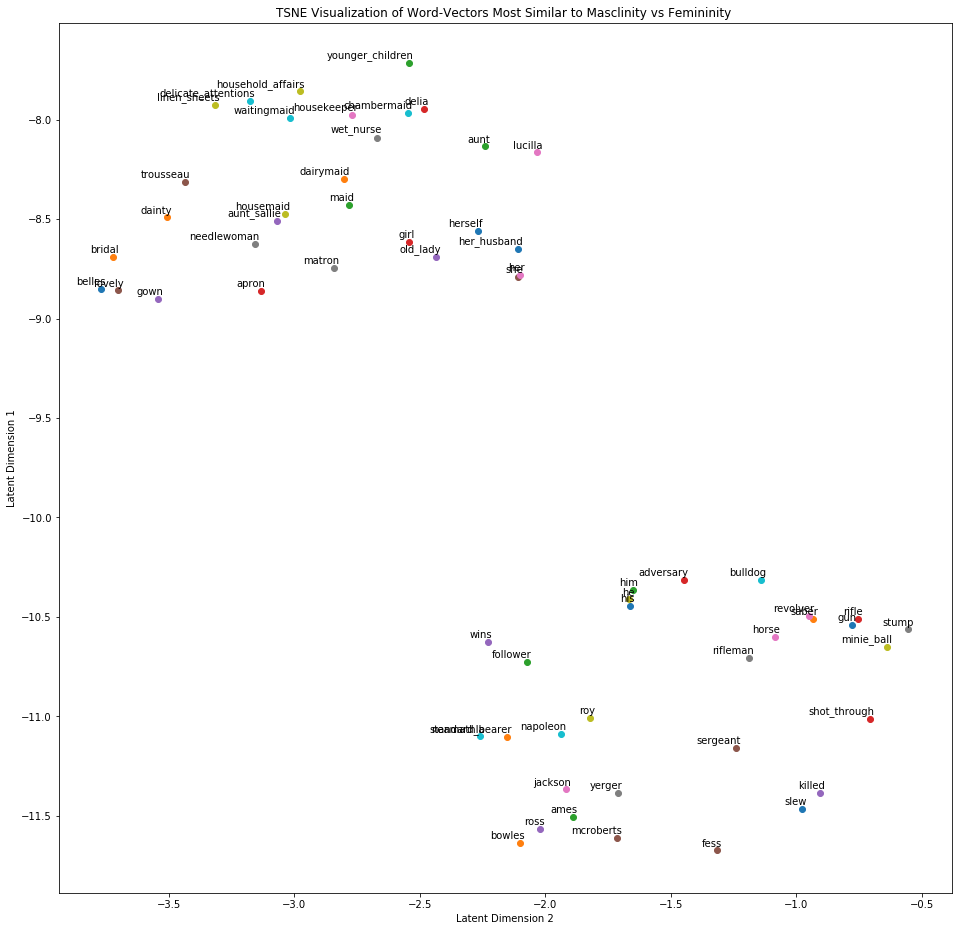

In [268]:
tsne_plot(person_word_list, person_word_vectors, 2500, 23,  "TSNE Visualization of Word-Vectors Most Similar to Masclinity vs Femininity ") #don't use too many words, won't finish running

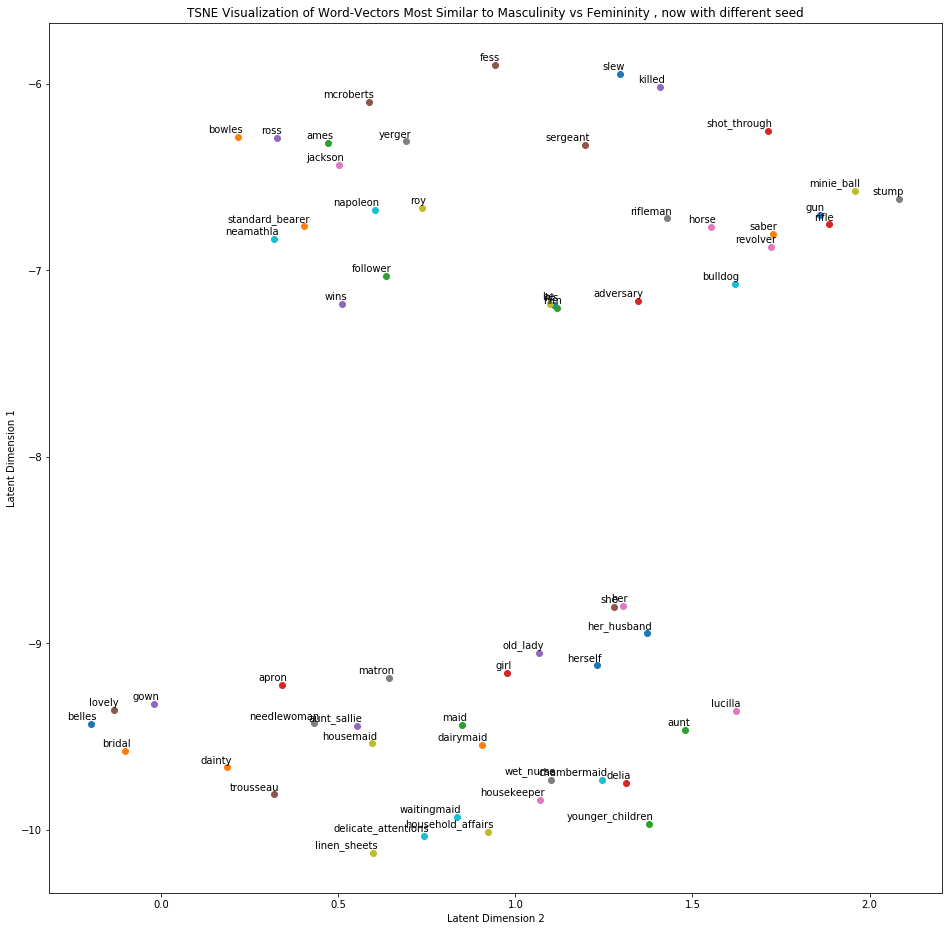

In [263]:
tsne_plot(person_word_list, person_word_vectors, 2500, 24,  "TSNE Visualization of Word-Vectors Most Similar to Masculinity vs Femininity , now with different seed") #don't use too many words, won't finish running

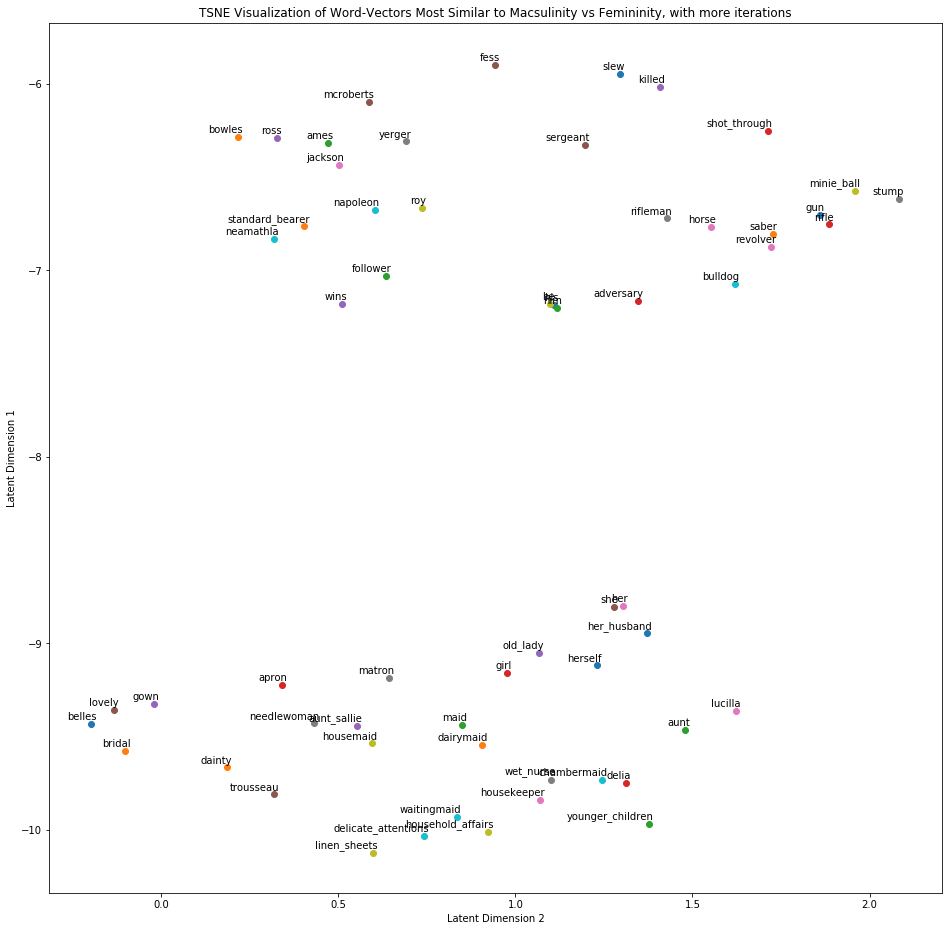

In [264]:
tsne_plot(person_word_list, person_word_vectors, 6500, 24,  "TSNE Visualization of Word-Vectors Most Similar to Macsulinity vs Femininity, with more iterations") #don't use too many words, won't finish running

TSNE allows us to visualize high-dimensional data (i.e., 100 dimensions, here) in just 2-dimensions, using the similarities between word-vectors to try to find the 2-D representation that best matches the 100-d representation of the data. In trying TSNE visualization of the word embeddings, I noticed that TSNE doesn't work well when I use groups of words that are already very related, such as when I tried to visualize words related to woman and man. Perhaps these cosine similarities are all very similar, and TSNE doesn't discriminate well between vectors with cosine similarities that are all very similar. Additionally, given that the vocabulary size is over 40,000, it is computationally expensive, and also visually uninteresting to try to see a graph of all words, epsecially since then we cannot distinguish the word-labels. So for this visualization, I stuck with lookin at the local patterns around feminine and masculine vectors. 

A more clear picture was painted when I tried looking at what the most "feminine" and "masculine" word vectors were. As described in the preceding section, I crudely measured femininity as the difference between 'woman' and 'man,' and masculinity as the difference between 'man' and 'woman.' They make sense, at first glance, as the more feminine (e.g, "dairymaid") words are clustered together, distinctly separated from the clustering of more masculine  words (e.g., "sergeant"), in all three visualizations. To assess the robustness of the visualization, I tried a different seed and more initializations, but all seem to produce similar clusters of words, and two distinct clusters of feminine, and masculine words.

## 4. Word Embeddings as Features

I'll now use the word embeddings as features ot predict authors' gender. I re-clean and structure the data as needed, manually annotate the 150 authors names for gender, and then use this to train a machine learning classifier to predict gender. 

Now, I need the documents in a different structure, so upload and clean again. This time, moving more quickly wihtout explanations through the pre-processing that is repeated

In [38]:
#upload text files, there should be 150 of them, 1 for each narrative. 
corpus =[]
filenames= []
for filename in os.listdir(cwd + '/first-person-narratives-american-south/data/texts'):
    narrative= open( cwd + '/first-person-narratives-american-south/data/texts/' + filename , 'r') 
    corpus.append(narrative.read())  #.decode('utf-8') if needed. 
    filenames.append(filename)

print(len(corpus)==150)
print(len(filenames)==150) #a check!

True
True


In [39]:
corpus_vecs_clean=[]
corpus_clean=[]
for document in corpus:
    #doc = re.sub(';?:!"', '.', document) #replace these with period, they will be splits for sentences
    doc= document.translate(None, string.punctuation)    
    doc = doc.translate(None, digits) #remove digits
    doc = doc.lower()  #make all letters lowercase
    doc = re.sub(r'\s+', ' ',   doc) #remove any extra white spaces, from https://lzone.de/examples/Python%20re.sub
    doc= doc.split( ' ') #split document into sentences
    #doc2 = [j.strip().split(' ') for j in doc] #split up each sentence into tokens and strip any extra whitespace if remaining
    for i in doc:
        filter(None, i) #get rid of empty tokens, '', some stubborn ones still here, but they will be eliminated later. 

    word_vecs_doc=[] #will populate this with the word-vectors for each word
    for i in doc:
        try:
            word_vecs_doc.append(currentmodel.wv[i])
        except KeyError, e: #looked up key errors in python to account for the vocab words that didn't occur often enough to learn embeddings for, https://stackoverflow.com/questions/16154032/catch-keyerror-in-python
            continue
    
    corpus_clean.append(doc) #attach sentences to corpus_clean, note this might now include a few ecctra word not in W2V vocab
    corpus_vecs_clean.append(word_vecs_doc)
    
del(corpus) #save up some space
len(corpus_clean)==150 #make sure still 150!

True

Now, I'll transform each document into a representation of its AVERAGE word (i.e., average word-vector). This "word" will be the input to a classifier model to predict gender of the author of the document. Using the average word is very coarse, but not unreasonable - Word2Vec trains itself using averages of word vectors as representations for contexts, to predict missing target words. But it sure does smooth over a lot of information in the documents and doesn't weight words by their importance or frequency. It's coarse, but let's see if it works.

In [40]:
doc_averages=[np.mean(i, axis=0) for i in corpus_vecs_clean] #getting average word vector of each document
len(doc_averages)==150 #check again
len(np.mean(corpus_vecs_clean[0], axis=0))==100 #a check that axis is correct, so that we are getting 100-D vectors out as averages

True

The meta data for this corpus of narratives is sparse. Based on author names, I manually annotated author genders as male or female. If I was unsure based on the name, I conducted a quick Google search, which in all cases quickly resolved the gender. I annotated gender with 0 as male, and 1 as female.   

In [41]:
meta= pd.read_csv(cwd+ '/first-person-narratives-american-south/data/toc_gender_annotated.csv')
meta #data that is annotated, take a look to make sure loads OK

#get a vector of author genders, based on order of filenames and documents: 
gender=[]
for i in filenames:
    file_temp= i.split('.')[0]
    file_temp= str(file_temp)+ str('.xml') #recorded as xml file not txt file in meta, so we need to look up using this
    gender_label= meta[meta['Filename']==file_temp] #looked at this site for reminders on working with pandas: https://pandas.pydata.org/pandas-docs/stable/indexing.html
    gender_label2= gender_label['Gender0Male'].values
    gender.append(gender_label2) #gender. this is pretty hacky but works. 

len(gender)==150 #check still 150! Good to also cross check gender/filename order with meta file

True

Now, **predict gender from doc_averages.** 

Split into training and testing sets. This is standard for machine-learning model training, and the *minimal* step to test for generalizability (overfitting) of a trained model. 

In [205]:
testing_set= random.sample(range(0,len(gender)), 20)  #lets keep 20 in testing set, or about 13% #Here and for the ML classifier training, I consulted my code from working with the depression data
training_set= [i for i in range(0,len(gender)) if i not in testing_set]

len(training_set)==130 #a check
set(training_set) != set(testing_set) #a second check

gender_train= [ gender[i] for i in training_set ] #error so used this help: https://stackoverflow.com/questions/1453882/python-error-list-indices-must-be-integers-they-are-integers
gender_test=  [ gender[i] for i in testing_set ]
doc_avg_train=  [ doc_averages[i] for i in training_set ]
doc_avg_test=  [doc_averages[i] for i in testing_set ]

gender_train=np.asarray(gender_train)
doc_avg_train=np.asarray(doc_avg_train)
gender_test=np.asarray(gender_test)
doc_avg_test=np.asarray(doc_avg_test)

**Train a SVM Classifier**

An SVM Classifier tries to learn a linear (at least, here, linear) separation between the two classes. We can make it more ore less strict of a separate by toying with the parameter "C."

Example use here, which I consulted: http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html . I also consulted my old code from trying to predict depression. 

In [252]:
classifier = svm.SVC(C=1, probability=False, class_weight={1: 2}) #add weights beause data is imabalanced about 2x the number of males compared to females, so weight females by 2 and males by 1. Note this reads WEIGHT GROUP 1 (females) as "2". 
classifier.fit(doc_avg_train, gender_train)

print(accuracy_score(gender_train, classifier.predict(doc_avg_train))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 females, all predicted maale. 
print(confusion_matrix(gender_train, classifier.predict(doc_avg_train))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 females, all predicted maale. 

0.6846153846153846
[[89  0]
 [41  0]]


First I ran this with C=1 (default for C) and noticed there are 41 females and 89 males, approximately 2 times as many males as females. While raw accuracy is high (68%), the confusion matrix reveals that all males were predicted. This is not surprising given that the data was imbalanced, so the "smart" prediction which gets highest raw accuracy is to predict all males. So, to correct for this I tried weighting the classes (weight of 1 for males and 2 for females). Still, all males were predicted. Clearly the algorithm is not learning. Still, I tried various parameters for "C" which is how strict or soft the separation is. In total, I tried .25, .5, 1, 3, 5, and 8, but in all cases, still only males were predicted! I did not try anything but using a linear kernel for the SVM classifier, since I felt the dataset was too small and high-dimensional (at 150 document averages, with 100 features each) for a model with more complexity - it would just overfit.

**Try training a random forest classifier as another attempt:**

Since the SVM model isn't working too well, I'll try a random forest classifier, which consists of an ensemble of decsision trees. Each tree tries to find a few "rules" or decision points successively separate out the classes. The trees are all a little bit different since they are created from bootstrapped versions of the data set, which helps prevent overfitting. 

For more info, which I also consulted, see here: http://scikitlearn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [281]:
classifier2= RandomForestClassifier(n_estimators=50, max_depth=2, max_features=None, random_state=23) #50 trees, usually more but there isn't much data. Here, only max depth of 2 meaning up to 2 decsision points. I also tried max depth of 3. 
classifier2.fit(doc_avg_train, gender_train)

print(accuracy_score(gender_train, classifier2.predict(doc_avg_train))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 females
print(confusion_matrix(gender_train, classifier2.predict(doc_avg_train))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 female

0.9384615384615385
[[87  2]
 [ 6 35]]


C:\Users\Alina Arseniev\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


First I ran this with 50 estimators and a depth of 3 decision points in a tree, and was surprised to see that 99% of the narratives were correctly predicted- and the confusion matrix looked good! Men were all correctly predicted, and only two women were misclassified as men. I fiddled with the features a bit to see how robust this is to hyperparametrization, such as trying a max depth of two. This still yielded high (94%) accuracy and a good looking confusion matrix (2 men classified as women, 6 women classified as men). **I am suspicious, however, of overfitting.** Ideally, I would do cross-validation, or at least would have blocked off a validation set in advance, but I had only done the classic split into testing and training sets. It is still helpful to go back and split up the training set into a "post hoc" validation set to see if overfitting is going on. This happens in the next block of code:

In [278]:
train_train_set= random.sample(range(0,len(training_set)), 20)  #lets keep 20 out of 130 in the validation set this time
valid_train_set= [i for i in range(0,len(training_set)) if i not in testing_set]  #remainder in the initial training set, now called train train

gender_traintrain= [ gender[i] for i in train_train_set ] #got an error at first, so used this for help: https://stackoverflow.com/questions/1453882/python-error-list-indices-must-be-integers-they-are-integers
gender_valid=  [ gender[i] for i in valid_train_set ]
doc_avg_traintrain=  [ doc_averages[i] for i in train_train_set ]
doc_avg_valid=  [doc_averages[i] for i in valid_train_set ]

classifier2_check= RandomForestClassifier(n_estimators=50, max_depth=2, max_features=None, random_state=23)
classifier2_check.fit(doc_avg_traintrain, gender_traintrain)

print(accuracy_score(gender_traintrain, classifier2_check.predict(doc_avg_traintrain))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 females
print(confusion_matrix(gender_traintrain, classifier2_check.predict(doc_avg_traintrain))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 female

1.0
[[11  0]
 [ 0  9]]


C:\Users\Alina Arseniev\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Now 100% accuracy and perfect confusion matrix, probably even more overfitted. Let's see how it does on the post-hoc validaton data: 

In [279]:
print(accuracy_score(gender_valid, classifier2_check.predict(doc_avg_valid))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 females
print(confusion_matrix(gender_valid, classifier2_check.predict(doc_avg_valid))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 female

0.7946428571428571
[[66  7]
 [16 23]]


Now a lot lower, accuracy at 76% and confusion matrix looks OK still (not predicting gjust one class or the other). So it was seriously overfitted as suspected. When I then see if this still happens with a depth of 2, it doesn't overfit so badly. Now, accuracy is at 79% and the confusion matrix still looks good. Let's move to the testing set.

In [280]:
print(accuracy_score(gender_test, classifier.predict(doc_avg_test))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 females
print(confusion_matrix(gender_test, classifier.predict(doc_avg_test))) #now ROW 0/1 is TRUE, COL 0/1 is PRED. Note that 89 males, 41 female

0.7
[[14  0]
 [ 6  0]]


This doesn't look so good! Accuracy is 70% but all males are predicted, just like we saw with SVM. I might have caught this with cross validation. 

There are a few reasons why these classifiers are not learning as currently designed, and why I do not have high expectations that they will work. First, the sample size is small, at only 150 (and just 135 for training!), although with high quality data a feature that very distinctly separates the data I would expect this to not be an issue. However, these narratives cross nearly 100 years of writing, and various levels of class and education, and so I expect that the writing styles are very diverse on more dimensions than just gender. Although I've seen a lot of work that can detect gender from writing style, teasing out just gender in this sample might be more difficult, especially if something like time is more salient for writing style. However, I did not want to classify narratives based on time since there are too few samples to chop up the corpus into different time points. Further, datasets that are imbalanced can be tricky to learn on even when the data or objective function is re-weighted. Another strategy could be to just drop some of the male examples (but then so few examples to learn on!), or to add additional, duplicated female samples which include a little bit of noise. The most important issue, however, I believe is the set of features used to learn gender from, which I created quite coarsely as the average "word." across 100 dimensions. I could additionally try other methods, but I think the data and representation is more of an issue than is the algorithm due to the previously listed reasons. If I were to investigate this data set and task further, I would use doc2vec or some other algorithm to learn a vector to represent each narrative directly, rather than create one by average in the words. Even better, I might chop up the data into paragraphs, and try to predict gender from paragraphs learned as vectors (still with Doc2vec, perhaps), which would also yield more training samples of writing style rather than smooshing these paragraphs into one to represent a single document. I might also explore using an LSTM framework to predict gender given a small window of words in the data, in which case I would again learn embeddings although these embeddings might be learned as a layer of the LSTM predicting gender, so that they are more attuned to the task at hand.

## 5. Polysemy

In [7]:
#Upload the saved model SG_100_10_1HS, since this is the model with the highest accuracy found above.
currentmodel=  word2vec.Word2Vec.load("SG_100_10_1HS")

Upload and clean corpus, for comments and detailed notes see beginning of notebook where this is first done. 

In [8]:
#upload text files, there should be 150 of them, 1 for each narrative. 
corpus =[]
for filename in os.listdir(cwd + '/first-person-narratives-american-south/data/texts'):
    narrative= open( cwd + '/first-person-narratives-american-south/data/texts/' + filename , 'r') 
    corpus.append(narrative.read())  #.decode('utf-8') if needed. 
len(corpus)==150 #a check!

corpus_clean=[]
for document in corpus:
    doc = re.sub(';?:!"', '.', document) #replace these with period, they will be splits for sentences
    doc = re.sub(r'[^\w\s.]', '', doc)  #remove all remaining punctuation except periods
    doc = doc.translate(None, digits) #remove digits
    doc = doc.lower()  #make all letters lowercase
    doc = re.sub(r'\s+', ' ',   doc) #remove any extra white spaces, from https://lzone.de/examples/Python%20re.sub
    doc= doc.split('.') #split document into sentences
    doc2 = [j.strip().split(' ') for j in doc] #split up each sentence into tokens and strip any extra whitespace if remaining
    for i in doc2:
        filter(None, i) #get rid of empty tokens, ''
    corpus_clean.extend(doc2) #attach sentences to corpus_clean

del(corpus) #save up some space

**First, I'll try detecting mulitple uses of the word "kind."**

According to the WordNet app, "kind" is a verb with four senses:
                                                                                      
1. (noun) kind, sort, form, variety -- (a category of things distinguished by some common characteristic or quality; "sculpture is a form of art"; "what kinds of desserts are there?")                                         
2. (verb) kind -- (having or showing a tender and considerate and helpful nature; used especially of persons and their behavior; "kind to sick patients"; "a kind master"; "kind words showing understanding and sympathy"; "thanked her for her kind letter")
3. (verb) kind, genial -- (agreeable, conducive to comfort; "a dry climate kind to asthmatics"; "the genial sunshine";"hot summer pavements are anything but kind to the feet")
4. (verb) kind, tolerant -- (tolerant and forgiving under provocation; "our neighbor was very kind about the window our son broke")

This word is a good case study for polysemy, since it has just four meanings which I see as more distinct than other possible word sense, (like "small" which has 13 senses according to WordNet but qualitaitvely I see these 13 senses as difficult to differnetiate, even for a human). 

Playing with WordNet via Python here, also played with App version:

In [9]:
# https://stackoverflow.com/questions/20896278/word-sense-disambiguation-algorithm-in-python

from textblob import Word 
import nltk 
from nltk.corpus import wordnet

word = Word("kind") #https://stevenloria.com/wordnet-tutorial/
word.synsets[:5]
word.definitions[:5]

synonyms = []   #https://www.geeksforgeeks.org/get-synonymsantonyms-nltk-wordnet-python/
for syn in wordnet.synsets("kind"):
    for l in syn.lemmas():
        synonyms.append(l.name())

print(set(synonyms)) #synonyms for kind

set([u'sort', u'kind', u'form', u'variety', u'genial', u'tolerant'])


Back to the data and the word 'Kind':

In [10]:
#Get a vector of the context sentences that include the word "kind":

sentences_kind = [i for i in corpus_clean if 'kind' in i] #could cluster using N from wordnet!
print(len(sentences_kind)) #2601 sentences use kind
cwords_kind=[item for sublist in sentences_kind for item in sublist if item is not 'kind'] #https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
print(len(cwords_kind))  #90,317 context words, a lot to work with!

2601
90317


For each context, create a context-vector as the average of word-vectors:

In [11]:
wordvecs_sent=[]
words_sent=[]

for i in sentences_kind: #for each sentence
    temp=[]
    temp2=[]
    for j in i: #for each word in sentences
        try:
            temp.append(currentmodel.wv[j])
            temp2.append(i)
        except KeyError, e: #looked up key errors in python to account for the vocab words that didn't occur often enough to learn embeddings for, https://stackoverflow.com/questions/16154032/catch-keyerror-in-python
            continue
    wordvecs_sent.append(temp)
    words_sent.append(temp2)
    
len(wordvecs_sent[0][0])==100 # a check for word vectors actually being there!

True

In [12]:
#Each sentence now needs to be represented as the AVERAGE word. these averages are what i will then cluster. 
sent_averages=[np.mean(i, axis=0) for i in wordvecs_sent]
len(sent_averages)==2601 #check again

True

Let's look at how well four senses, versus other number of senses, fits the data:

I use k-means to cluster these averaged context vectors, with models ranging between 1 and 20 clusers so we can see if 4 is where there is an "elbow" or a turning point in the fit.

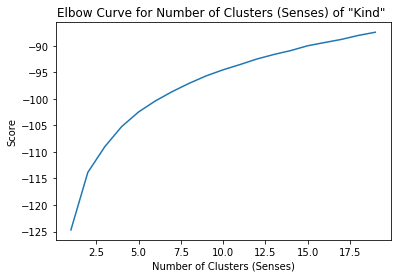

In [30]:
#Adapted from http://www.michaeljgrogan.com/k-means-clustering-python-sklearn/

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(sent_averages).score(sent_averages) for i in range(len(kmeans))]
#score
pl.plot(Nc,score)
pl.xlabel('Number of Clusters (Senses)')
pl.ylabel('Score')
pl.title('Elbow Curve for Number of Clusters (Senses) of "Kind" ')
pl.show()

Looks like the elbow isn't so clear here! But eye-balling it, it would be somewhere around 5, so not necessarily too far off, but it would have been more encouraging to see a sharp elbow at 4. 

Lets still run with 4 senses and see how well it works qualitatively. 

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=23).fit(sent_averages) #http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
preds= kmeans.predict(sent_averages)

In [ ]:
#I'll annotate a 10 random sentences with "kind" to check how this is doing: 

#for x in range(0,10):
    #print(random.randint(1,2601))  #get random numbers for contexts to look at

sents= [sentences_kind[318] , sentences_kind[650] , sentences_kind[833] , sentences_kind[2233] , sentences_kind[356] , sentences_kind[1749] , sentences_kind[2460] , sentences_kind[1078] , sentences_kind[2360], sentences_kind[2013] ]
rand_indices= [318, 650, 833, 2233, 256, 1749, 2460, 1078, 2360, 2013] #record context indices
annotations= [2,1,2,1,1,2,2,2,2,1] #record my annotations

for i in rand_indices:
    print(preds[i]) #print out the predicted clusters, noting these are not indexed in the same way as my annotations. 

**10 annotations versus predicted senses for 'Kind'**

| Random Sentence Index   |      Alina annotation      |   Cluster predicted      | 
|----------|:-------------:|:-------------:|
| 318 | Kind_2 |  3 | 
| 650  |   Kind_1  |   0 | 
| 833  | Kind_2 |  2 | 
| 2233 | Kind_1  |   2 | 
| 256 | Kind_1 |    0 | 
| 1749 |  Kind_2 |   3 | 
| 2460 |  Kind_2 |   2 | 
| 1078 |  Kind_2 |   1 | 
| 2360 |   Kind_2 |   2 | 
|  2013 |  Kind_1 |   2 | 

*Note that the true cluster number does NOT necessarily coordinate to the sense number. But a better peforming algorithm would contain clusters with members of the same class from one annotation/algorithm as another, and clusters would not include members of other classes.  


Wow! These do NOT match what I had in mind. Among those that I thought were kind_1, half were labeled cluster 0 and half clusetr 2. Among those that I annotated as kind_2, 2 were labeled as cluster 3, 4 as cluter 2, and 1 as cluster 1! 

Among the many issues with this coarse appporach to exploring polysemy is possible that a sense prsent in WordNet might be either very rare or totally unrepresented in this corpus. It is also possible that I did not annotate in the way intended by WordNet- I found only two senses in the 10 samples, and honestly I don't think I am able to differentiate between kind 2 and the kind 3 and 4. 

**Let's try this again,** with a word that has even more distinct and fewer meanings, like "pray". Code now lumped together.

The verb pray has 2 senses, according to WordNet:
                                           
1. pray -- (address God; say a prayer)
2. beg, implore, pray -- (call upon in supplication; entreat; "I beg you to stop!")

574
18849


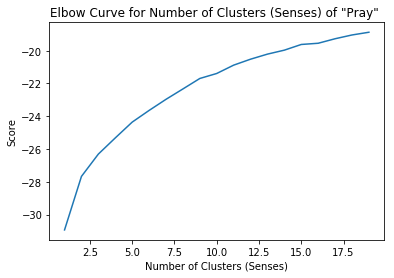

In [16]:
#Get a vector of the context sentences that include the word "kind":

sentences_kind = [i for i in corpus_clean if 'pray' in i] #could cluster using N from wordnet!
print(len(sentences_kind)) #574 sentences use kind, not many but may be OK
cwords_kind=[item for sublist in sentences_kind for item in sublist if item is not 'pray'] #https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
print(len(cwords_kind))  

wordvecs_sent=[]
words_sent=[]

for i in sentences_kind: #for each sentence
    temp=[]
    temp2=[]
    for j in i: #for each word in sentences
        try:
            temp.append(currentmodel.wv[j])
            temp2.append(i)
        except KeyError, e: #looked up key errors in python to account for the vocab words that didn't occur often enough to learn embeddings for, https://stackoverflow.com/questions/16154032/catch-keyerror-in-python
            continue
    wordvecs_sent.append(temp)
    words_sent.append(temp2)
    
len(wordvecs_sent[0][0])==100 # a check for word vectors actually being there!

#Each sentence now needs to be represented as the AVERAGE word. these averages are what i will then cluster. 
sent_averages=[np.mean(i, axis=0) for i in wordvecs_sent]

#Adapted from http://www.michaeljgrogan.com/k-means-clustering-python-sklearn/

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(sent_averages).score(sent_averages) for i in range(len(kmeans))]
#score
pl.plot(Nc,score)
pl.xlabel('Number of Clusters (Senses)')
pl.ylabel('Score')
pl.title('Elbow Curve for Number of Clusters (Senses) of "Pray" ')
pl.show()

Again it is really hard to tell, even thought I thought that "pray" will be more distinct and have fewer meanings! 

In [85]:
kmeans = KMeans(n_clusters=2, random_state=23).fit(sent_averages) #http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
preds= kmeans.predict(sent_averages)

In [86]:
#I'll annotate a 10 random sentences with "pray" to check how this is doing: 

#for x in range(0,10):
    #print(random.randint(1,98)) 

sent = [sentences_kind[29], sentences_kind[58] ,sentences_kind[95] , sentences_kind[14] , sentences_kind[13] , sentences_kind[56] ,sentences_kind[68] , sentences_kind[96] , sentences_kind[38], sentences_kind[85] ]
#sentences_kind[95] is almost sense 2, but seems like a different sense to me! "'how', 'pray', 'my', 'good', 'doctor', ..."
#rand_indices= [29, 58,95,14,13,56,68,96,38,85]
#annotations= [2 ,1, 2, 1, 1, 1, 1, 2, 1, 1] 

for i in rand_indices:
    print(preds[i])

0
0
1
0
0
0
1
1
1
0


**10 annotations versus predicted senses for 'Pray'**

| Random Sentence Index   |      Alina annotation      |   Cluster predicted      | 
|----------|:-------------:|:-------------:|
| 29 | Pray_2 |  0 | 
| 58  |   Pray_1  |   0 | 
| 95  | Pray_2 |  1 | 
| 14 | Pray_1  |   0 | 
| 13| Pray_1 |    0 | 
| 56 |  Pray_2 |   0 | 
| 68 |  Pray_2 |   1 | 
| 96 |  Pray_2 |   1 | 
| 38 |   Pray_2 |   1 | 
|  85 |  Pray_1 |   0 | 

*Note that the true cluster number does NOT necessarily coordinate to the sense number. But a better peforming algorithm would contain clusters with members of the same class from one annotation/algorithm as another, and clusters would not include members of other classes.  


Again, these do NOT really match what I had in mind. Among the four contexts that I thought were pray_1, all were labeled cluster 0. Among the six that I thought were pray_1,  2 were predicted as cluster 0 and  4  were predicted as cluster 1. Again, this is suprising that it doens't match my own annotations, even in this simplified case of "pray"!

In [25]:
#Let's compare to an existing algorithm the Lesk algorithm in NLKT: #referred to: http://www.nltk.org/howto/wsd.html

from nltk.wsd import lesk
from nltk.corpus import wordnet as wn

from nltk.wsd import lesk
sent = [sentences_kind[29], sentences_kind[58] ,sentences_kind[95] , sentences_kind[14] , sentences_kind[13] , sentences_kind[56] ,sentences_kind[68] , sentences_kind[96] , sentences_kind[38], sentences_kind[85] ]

for i in sent:
    print(lesk(i, 'pray'))

Synset('pray.v.01')
Synset('pray.v.01')
Synset('pray.v.01')
Synset('beg.v.01')
Synset('beg.v.01')
Synset('pray.v.01')
Synset('pray.v.01')
Synset('pray.v.01')
Synset('pray.v.01')
Synset('pray.v.01')


**10 annotations versus predicted senses for 'Pray' via clustering contexts with K-means, and via Lesk Algorithm**

| Random Sentence Index   |      Alina annotation      |   Cluster predicted      | Lesk Predicted
|----------|:-------------:|:-------------:|:-------------:|
| 29 | Pray_2 |  0 | pray.v.01|
| 58  |   Pray_1  |   0 | pray.v.01|
| 95  | Pray_2 |  1 | pray.v.01|
| 14 | Pray_1  |   0 | beg.v.01|
| 13| Pray_1 |    0 | beg.v.01|
| 56 |  Pray_2 |   0 | pray.v.01|
| 68 |  Pray_2 |   1 | pray.v.01|
| 96 |  Pray_2 |   1 | pray.v.01||
| 38 |   Pray_2 |   1 | pray.v.01|
|  85 |  Pray_1 |   0 | pray.v.01|

*Note that the true cluster number does NOT necessarily coordinate to the sense number. But a better peforming algorithm would contain clusters with members of the same class from one annotation/algorithm as another, and clusters would not include members of other classes.  


Interesting! My annotations do not agree well with those predicted by Lesk, either. And, Lesk annotations do not agree well with those predicted by K-means clustering of contexts. Of course, on just 10 samples it is hard to tell, and this should be re-run with a labeled, standard corpus for word sense induction/disambiguation to better judge performance. And, while I'm just exploring models but on these datasets the model should be developed with a testing/training framework like any other machine-learning model. But its clear from the above how hard it might be to develop a good model to resolve polysemy! One issue clear in these attempts is clear that meaning is subjective, including what constitutes its own "sense." This is the case even for a seemingly simple word like "pray." In fact, it took a while to find examples "pray" and "kind" which had fewer senses than most polysemous words I looked up in WordNet, thinking they would have few or at least very distinct senses. Another issue that is clear is that it is necessary to use a corpus labeled with senses in developing an algorithm, to compare algorithms to published, state of the art models not as easily implemented as the Lesk algorithm, and to be able to identify external validity as well. Further, it is unclear exactly how to choose the number of senses in clustering algorithms which wants this to be pre-set, especially when working at a corpus level rather than a word-level as I have done here. Using an external knowledge source like WordNet, could resolve this, but it is possible - even likely - that not all senses of a word will be represented, or represented well enough for detection. While I used the number of senses from Wordnet as the "k" in k-means for both "pray" and "kind," it was not clear from both elbow plots that this was the number of senses in the dataset. It may be better to use clustering algorithms that do not require a pre-set number of clusters. And, even more fruitful may be to investigate higher level semantic rules or heuristics for when a new sense becomes accepted versus just a contextualized meaning, perhaps using a few case studies and multiple peoples' annotations.